# Linear models, Optimization

## Two-dimensional classification

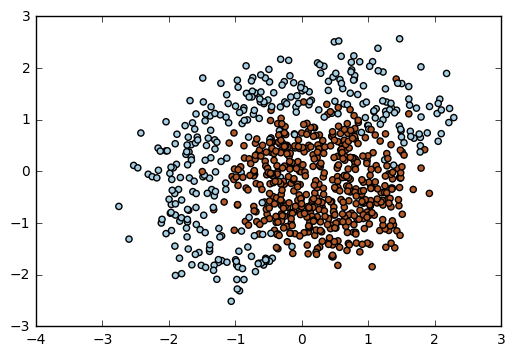

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from IPython import display
from sklearn import datasets, preprocessing

(X, y) = datasets.make_circles(n_samples=1024, shuffle=True, noise=0.2, factor=0.4)
ind = np.logical_or(y==1, X[:,1] > X[:,0] - 0.5)
X = X[ind,:]
m = np.array([[1, 1], [-2, 1]])
X = preprocessing.scale(X)
y = y[ind]
y = 2*y - 1
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.show()

In [2]:
h = 0.01
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
def visualize(X, y, w, loss, n_iter):
    plt.clf()
    Z = classify(np.c_[xx.ravel(), yy.ravel()], w)
    Z = Z.reshape(xx.shape)
    plt.subplot(1,2,1)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.subplot(1,2,2)
    plt.plot(loss)
    ymin, ymax = plt.ylim()
    plt.ylim(0, ymax)
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
def expand(X):
    X_ = np.zeros((X.shape[0], 6))
    X_[:,0:2] = X
    X_[:,2:4] = X**2
    X_[:,4] = X[:,0] * X[:,1]
    X_[:,5] = 1
    return X_

def classify(X, w):
    
    dotproduct = expand(X).dot(w)
    
    return np.sign(dotproduct)

def compute_loss(X, y, w):
    
    dotproduct = expand(X).dot(w)
    
    margin = dotproduct * y
    
    #warning, np.maximum is not same as np.max, read the description!
    hinge = np.maximum(0,1-margin)
    
    return np.mean(hinge)
    

def compute_grad(X, y, w):
    
    X_exp = expand(X)

    dotproduct = X_exp.dot(w)
    
    margin = dotproduct * y
    
    
    # if True, gradient is zero. (where hinge loss equals 0)
    is_zero =  1 - margin  <= 0
    
    #gradients for each sample of shape [n_samples, n_features]
    
    #margin = X*w * y , derivative of margin over W = X*y
    #derivative of max(1-margin,0) is -margin if 1-margin>0, else 0
    
    grad_term = -(X_exp*y[:,None]) * (~is_zero[:,None])
    #                     ^-- [:,None] transforms vector of [samples] into
    #                          a column-matrix [samples,1] in order for numpy
    #                          to multiply it over X_exp by broadcasting.
    
    #sum over samples batch
    return grad_term.sum(axis=0)
        

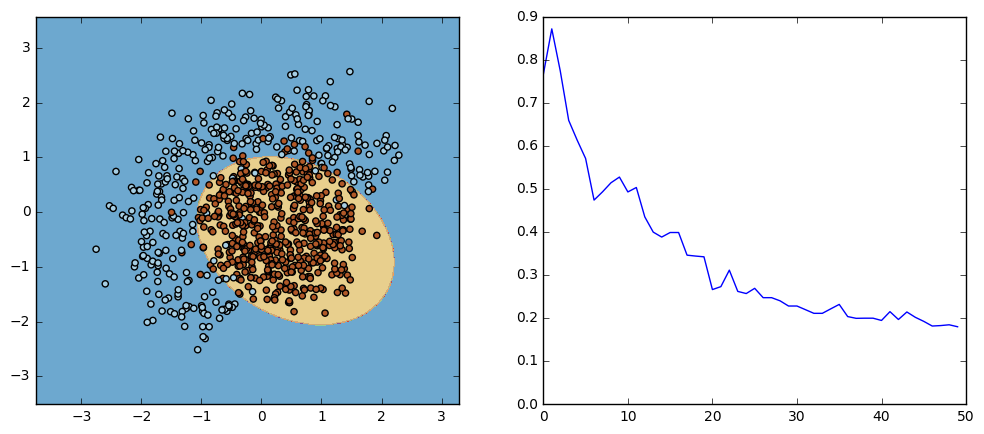

In [25]:
w = np.array([1,0,0,0,0,0])

alpha = 0.05 # learning rate

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    w = w - alpha * compute_grad(X[ind,:], y[ind], w)

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement gradient descent with momentum

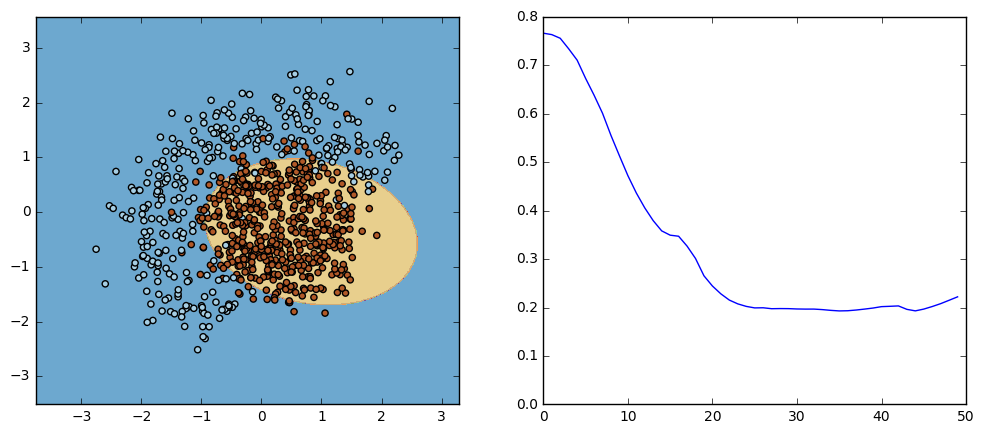

In [37]:
w = np.array([1,0,0,0,0,0])

alpha = 0.009 # learning rate
mu    = 0.9   # momentum
step  = 0     # gradient step

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    step = alpha * compute_grad(X[ind,:], y[ind], w) + mu * step
    w = w - step

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement RMSPROP algorithm

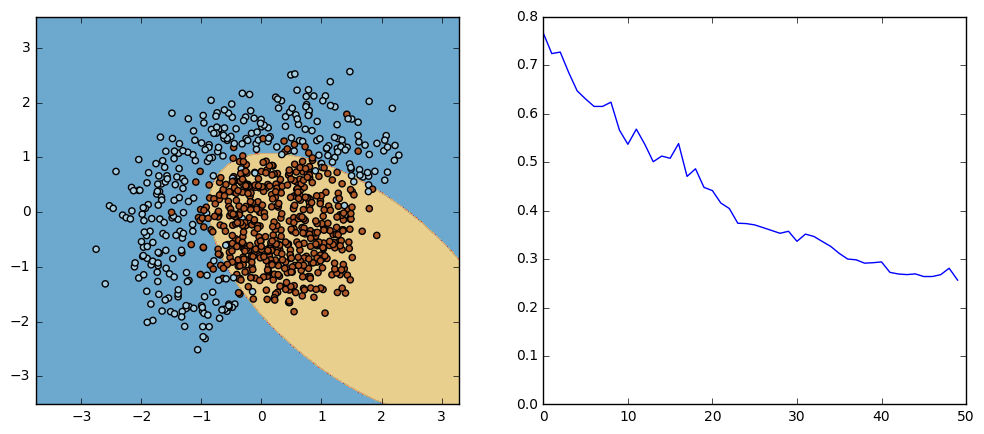

In [40]:
w = np.array([1,0,0,0,0,0])

alpha = 0.05 # learning rate
mu    = 0.9  # forgetting factor
avg_past = 1 # decaying average of all past squared gradients

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    avg_past = mu * avg_past + (1-mu) * (compute_grad(X[ind,:], y[ind], w) ** 2)
    w = w - alpha / (np.sqrt(avg_past)) * compute_grad(X[ind,:], y[ind], w) 

visualize(X, y, w, loss, n_iter)
plt.clf()

Implement AdaGrad algorithm

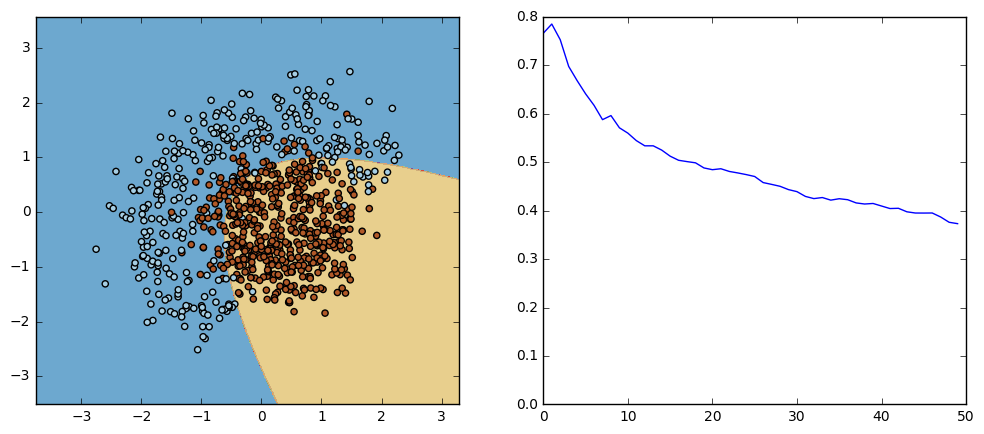

In [38]:
w = np.array([1,0,0,0,0,0])

alpha = 0.1 # learning rate
sum_sqr_grad = np.zeros(len(w)) # sum of squares of the gradients

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    grad = compute_grad(X[ind,:], y[ind], w)
    sum_sqr_grad += grad ** 2
    
    w = w - alpha / (np.sqrt(sum_sqr_grad)) * compute_grad(X[ind,:], y[ind], w)    
    
visualize(X, y, w, loss, n_iter)
plt.clf()

Implement Adam algorithm

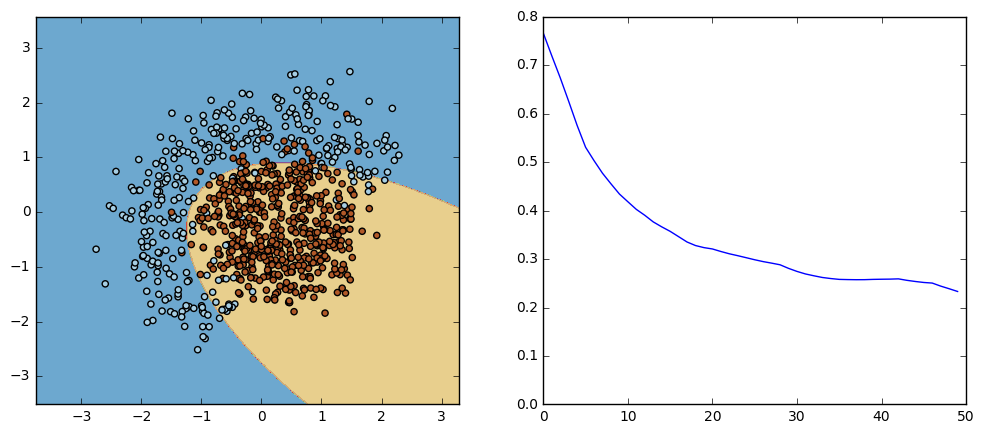

In [46]:
w = np.array([1,0,0,0,0,0])

alpha = 0.05 # learning rate
beta1    = 0.9 
beta2    = 0.999
first_moment = np.zeros(len(w))
second_moment = np.zeros(len(w))

n_iter = 50
batch_size = 4
loss = np.zeros(n_iter)
plt.figure(figsize=(12,5))
for i in range(n_iter):
    ind = random.sample(range(X.shape[0]), batch_size)
    loss[i] = compute_loss(X, y, w)
    visualize(X[ind,:], y[ind], w, loss, n_iter)
    
    first_moment = beta1 * first_moment + (1- beta1) * compute_grad(X[ind,:], y[ind], w)   
    second_moment = beta2 * second_moment + (1 - beta2) * (compute_grad(X[ind,:], y[ind], w) ** 2)
    
    est_first_moment = first_moment / (1 - beta1)
    est_second_moment = second_moment / (1- beta2)
    
    w = w - alpha / (np.sqrt(est_second_moment)) * est_first_moment

visualize(X, y, w, loss, n_iter)
plt.clf()